In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


#This should be changed to link directly to the folder where this notebook is on the machine (see setup_instructions.txt)

%cd /Users/babakhessamian/Google Drive/My Drive/MSC/Modules/Core/INM427 - Neural Computing/Coursework/Submission


/Volumes/GoogleDrive/My Drive/MSC/Modules/Core/INM427 - Neural Computing/Coursework/My Coursework


In [2]:
# This notebook does not use any special libraries. 
# However, the following are necessary:

# $ conda install -c conda-forge imbalanced-learn
# $ conda install -c conda-forge skorch
# $ conda install -c pytorch pytorch

# Versions:

# imbalanced-learn          0.7.0                      py_1    conda-forge
# skorch                    0.10.0             pyh59e0f4d_0    conda-forge
# pytorch                   1.8.1                   py3.8_0    pytorch


# Data Exploration

We put our data in to a pandas DataFrame to help with our decision making when we develope our models.

In [3]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


No missing values. We do have two different data types, int64 and float64. This does not matter as we will change these types later for our model analysis. 

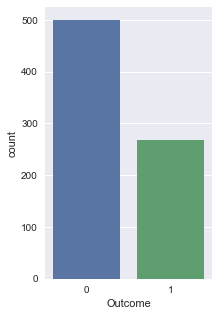

In [6]:
plt.figure(figsize=(3,5))
plt.style.use('seaborn')
class_imbalance = sns.countplot(x = 'Outcome', data = df) 

# Save the figure to use in the report
#class_imbalance.figure.savefig("classimbalance.png")

There is a mild class imbalance. So we will try Synthetic Minority Oversampling Technique to address this. 

<AxesSubplot:>

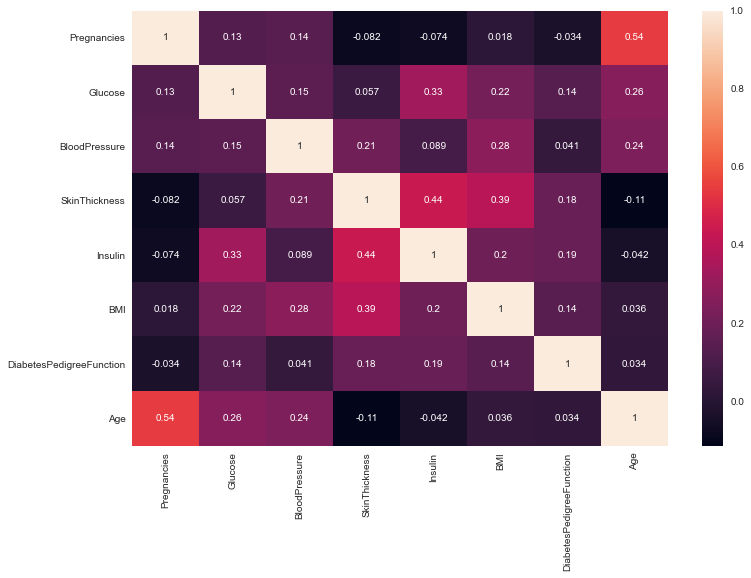

In [7]:
plt.figure(figsize=(12,8))
sns.heatmap(df[df.columns[:8]].corr(),annot=True)

A correlation heatmap to make sure there are no strong correlations between certain variables.

<Figure size 1440x1440 with 0 Axes>

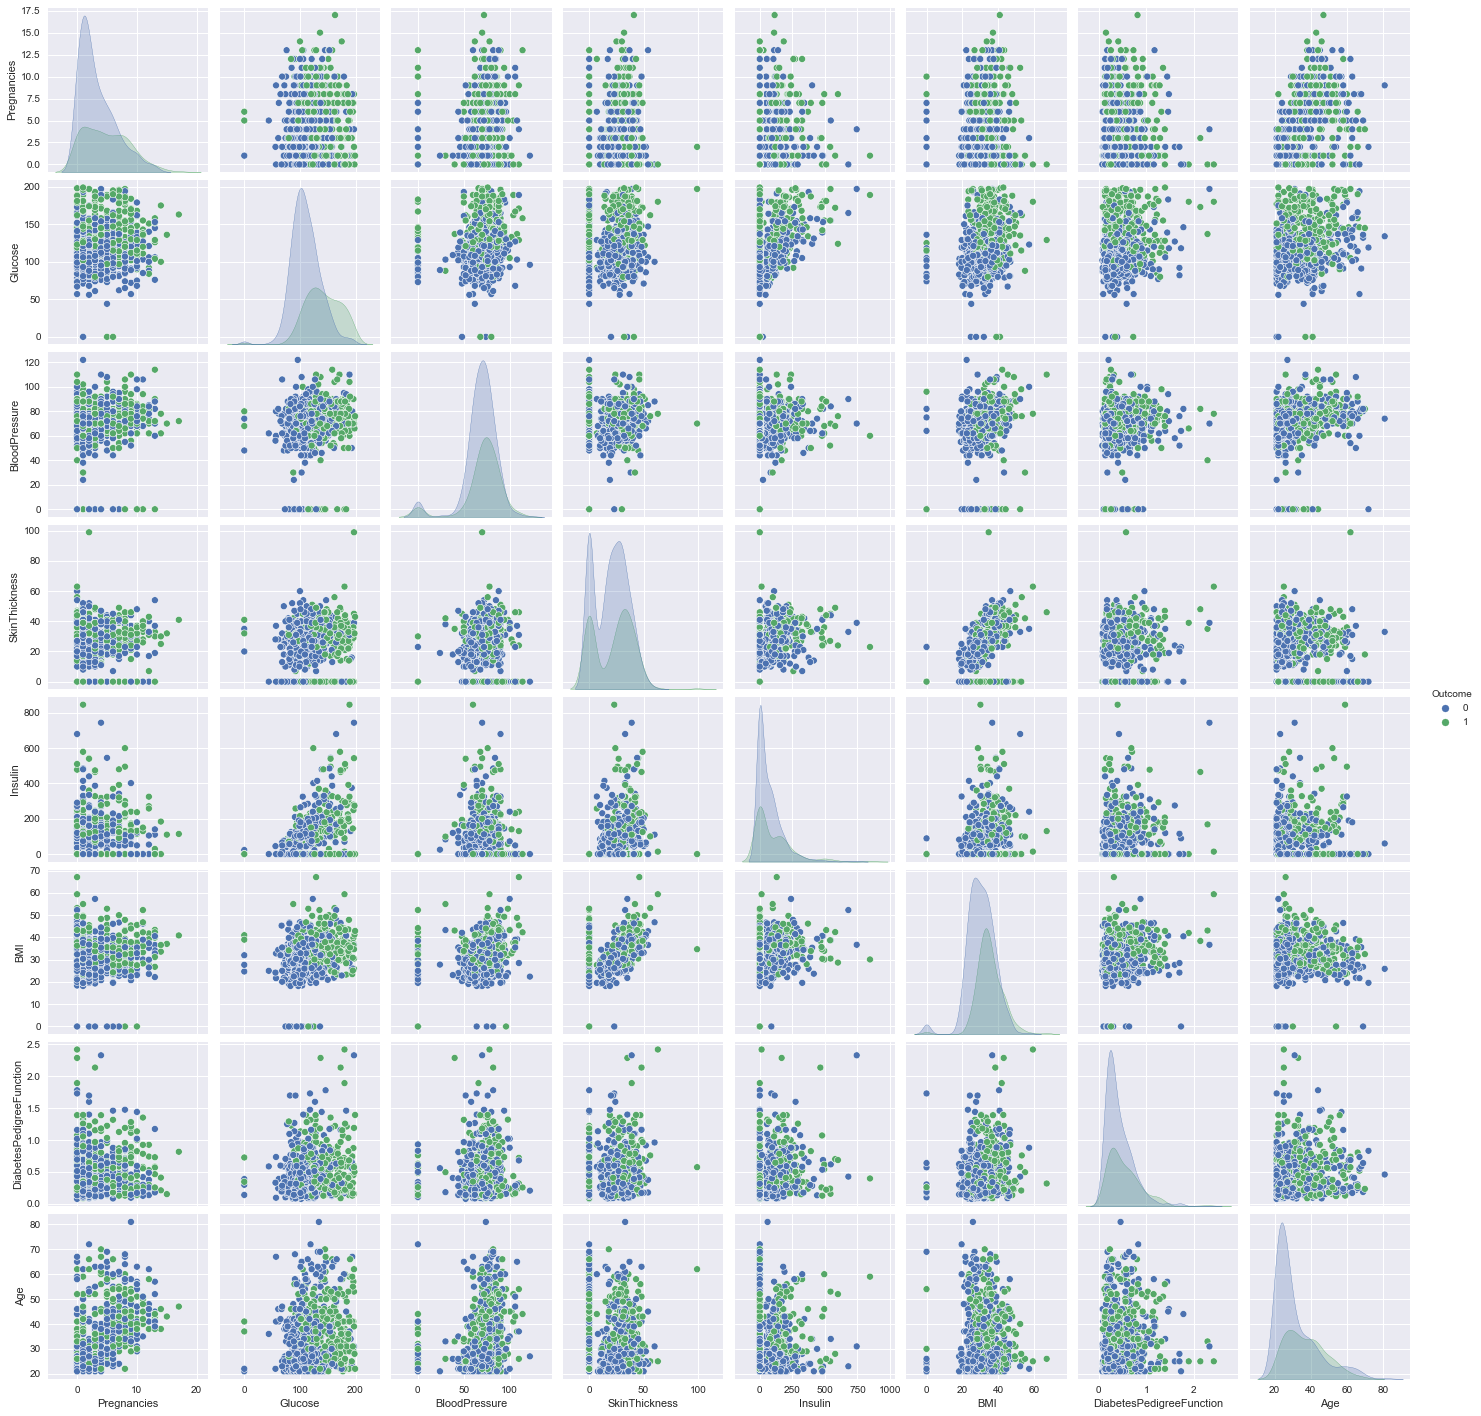

In [8]:
plt.figure(figsize=(20,20))
pairwise_scatterplot = sns.pairplot(df, hue="Outcome")

# Save the figure to use in the report
#pairwise_scatterplot.savefig("output.png")

These pairwise scatterplots help identify outliers as well as revealing the stronger predictors. More explanation in the report. 

# Building Models

## Data Preparation

In [9]:
# Importing the data from CSV into a numpy array. This makes things easier, especially for MLP. 
data = np.genfromtxt('diabetes.csv',delimiter=',', dtype=float)
print (data.shape)

(769, 9)


In [10]:
# Splitting the input and target variables. We miss out the first row which contains column names.
X = data[1:,:8]
y = data[1:,[8]]

In [11]:
# This is needed to be able to use Pytorch and Skorch.
X = X.astype('float32')
y = y.astype('int64')

In [12]:
# Splitting the input and output variables into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [13]:
# The data is imbalanced. So we use SMOTE to balance the positive and negative classes. 
# This conclusion was reached after several iterations. 

import imblearn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 42)

# Only applied to training set.
X_sm, y_sm = sm.fit_resample(X_train, y_train)

In [14]:
# There is a lot of variation in this dataset as seen in the pairwise scatterplots above.
# So we standardise our training and test data. But not the target variable. 

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

sc = sc.fit(X_sm)

In [15]:
# We then use the scaler to transform the X sets. 
X_sm = sc.transform(X_sm)

X_test = sc.transform(X_test) 

We do not use tensors as we let skorch to figure things out. If our datasets were bigger, then maybe using tensors would have helped speed up skorch.

In [16]:
# The target dimension has to be (n,) for skorch NeuralNetClassifier. The test and train target dimension have to match. 
# So here we match the dimension of the test target with the train target: both have a dimension of (n,)

y_test = y_test.squeeze(1)


In [17]:
# Check the dimenion of the test target.
y_test.shape

(192,)

In [18]:
# Check the dimension of our scaled, transformed, and oversampled training sets. 
X_sm.shape, y_sm.shape

((740, 8), (740,))

# Multi-Layer Perpectron

Now it's time to develop our first model: Multi-Layer Perpectron. 

In [19]:
import torch
from torch import nn

In [20]:
# define the structure of the neural network
class ClassifierModule1(nn.Module): 
  
    def __init__(self):
        super(ClassifierModule1, self).__init__()
        self.dropout = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(8, 32) # 8, as we have 8 variables in out dataset
        self.fc2 = nn.Linear(32, 16)       
        self.fc3 = nn.Linear(16, 2) # 2, as we are solving a binary classification problem
        self.sigmoid = torch.nn.Sigmoid() # we use this for the output layer as it is recommended for binary classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        
        x = self.fc2(x)        
        
        x = self.fc3(x)
        x = self.sigmoid(x) # Sigmoid applied to the output
        
        return x

In [21]:
from skorch import NeuralNetClassifier

The three below cells were used to grid search for the best parameters. These parameters are used again to train and fit a model. So no need to re-run the blow three cells.

In [22]:
# We dont run the algortihm directly. 
# Instead we wrap it into a neuralnet classifier class. 

#torch.manual_seed(0) 

#net = NeuralNetClassifier(
#    ClassifierModule1,
#    max_epochs=20, # Maximum number of epochs
#    lr=1, # Learning rate
#)

In [23]:
# Perform a grid search to find the best parameters for the learning rate and maximum number of epochs.

#from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
#params = {'lr': [0.0001, 0.1, 0.5, 0.7, 1], 
#          'max_epochs': [20, 50, 75]
#         }


# perform grid search with 5 fold cross validation
#gsMLP = GridSearchCV(net, params, refit = False, cv=5, scoring='accuracy') 

# fit the model
#gsMLP.fit(X_sm, y_sm)

# print best scores and model performance
#print(gsMLP.best_score_, gsMLP.best_params_)


In [171]:
# let's look at the best parameters again
#print(gsMLP.best_score_, gsMLP.best_params_)

0.7621621621621621 {'lr': 1, 'max_epochs': 50}


In [44]:
# wrap the net into the nearal net classifier again with the best parameters.
net_after_GS = NeuralNetClassifier(
    ClassifierModule1,
    max_epochs=50,
    lr=1,
)

In [46]:
# fit the model with best parameters to training data
net_after_GS.fit(X_sm, y_sm)

Re-initializing module.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4181       0.6892        0.0641  0.0140
      2        0.0401       0.7095        0.0158  0.0121
      3        0.0141       0.7500        0.0073  0.0122
      4        0.0074       0.7500        0.0044  0.0114
      5        0.0048       0.7500        0.0031  0.0149
      6        0.0037       0.7568        0.0023  0.0135
      7        0.0028       0.7500        0.0018  0.0131
      8        0.0026       0.7568        0.0015  0.0112
      9        0.0020       0.7500        0.0012  0.0111
     10        0.0016       0.7568        0.0010  0.0126
     11        0.0014       0.7500        0.0009  0.0123
     12        0.0014       0.7500        0.0008  0.0112
     13        0.0013       0.7500        0.0007  0.0116
     14        0.0011       0.7568        0.0006  0.0129
     15        0.0009       0.7568   

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule1(
    (dropout): Dropout(p=0.25, inplace=False)
    (fc1): Linear(in_features=8, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=2, bias=True)
    (sigmoid): Sigmoid()
  ),
)

In [47]:
# predict using the mdoel with best parameters

y_pred_GS = net_after_GS.predict(X_test)

In [48]:
# check the accuracy of the model
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_GS)

0.765625

In [49]:
# check classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_GS)) 

              precision    recall  f1-score   support

           0       0.87      0.77      0.82       130
           1       0.61      0.76      0.68        62

    accuracy                           0.77       192
   macro avg       0.74      0.76      0.75       192
weighted avg       0.79      0.77      0.77       192



In [50]:
# check confusion matrix
from sklearn.metrics import confusion_matrix
cm_MLP = confusion_matrix(y_test, y_pred_GS)
print(cm_MLP) 

[[100  30]
 [ 15  47]]


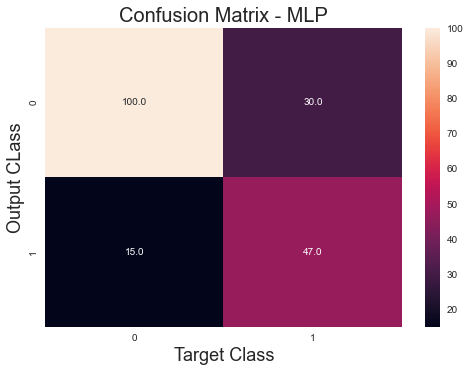

In [52]:
# plot confusion matrix
sns.heatmap(cm_MLP, annot = True, fmt = '.1f')
plt.title('Confusion Matrix - MLP', fontsize=20)
plt.xlabel('Target Class', fontsize= 18)
plt.ylabel('Output CLass', fontsize=18)
#plt.savefig('Confusion Matrix - MLP')
plt.show()

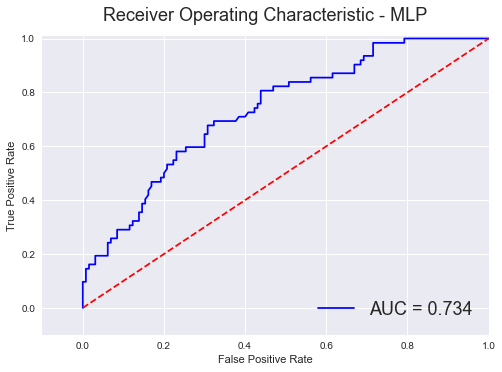

In [31]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# We check the ROC curve. The sharp elbow is because out prediction is binary and is not the probability of each class

# we calculate a probability to avoid our ROC curve having an elbow shape.
yhat_N = net_after_GS.predict_proba(X_test)
pos_probs_N = yhat_N[:, 1]

# Ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

fpr, tpr, thresholds = roc_curve(y_test, pos_probs_N)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic - MLP', fontsize = 18, y = 1.03)
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right', fontsize = 18)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('Receiver Operating Characteristic - MLP')
plt.show()

In [32]:
#We get the number of epochs and the train and validation losses to produce a loss learning curve.
#epochs = [i for i in range(len(net_after_GS.history))]
#train_loss = net_after_GS.history[:,'train_loss']
#valid_loss = net_after_GS.history[:,'valid_loss']

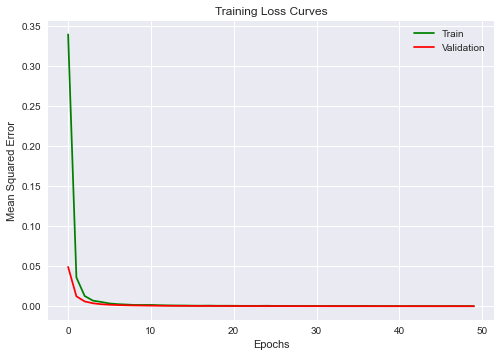

In [181]:
# plotting the the losses vs epochs
#plt.plot(epochs,train_loss,'g-');
#plt.plot(epochs,valid_loss,'r-');
#plt.title('Training Loss Curves');
#plt.xlabel('Epochs');
#plt.ylabel('Mean Squared Error');
#plt.legend(['Train','Validation']);

In [33]:
from sklearn.model_selection import learning_curve

# we plot the accuracy learning curve of our model with best parameters: net_after_GS

train_sizes_MLP, train_scores_MLP, validation_scores_MLP = learning_curve(net_after_GS, X = X_sm, y = y_sm, 
                                                                          scoring="accuracy", cv=5)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7353       0.9167        0.3431  0.0033
      2        0.1941       0.9167        0.2369  0.0034
      3        0.0854       0.9167        0.1833  0.0029
      4        0.0727       0.9167        0.1476  0.0030
      5        0.0544       0.9167        0.1311  0.0036
      6        0.0373       0.9167        0.1105  0.0026
      7        0.0305       0.9167        0.0979  0.0024
      8        0.0231       0.9167        0.0938  0.0032
      9        0.0228       0.9167        0.0869  0.0042
     10        0.0197       0.9167        0.0776  0.0028
     11        0.0152       1.0000        0.0720  0.0027
     12        0.0130       1.0000        0.0662  0.0025
     13        0.0130       1.0000        0.0621  0.0039
     14        0.0113       1.0000        0.0582  0.0036
     15        0.0102       1.0000        0.0550  0.0035
     16        0.0092       1.0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


     44        0.0033       1.0000        0.0212  0.0029
     45        0.0026       1.0000        0.0206  0.0029
     46        0.0028       1.0000        0.0207  0.0040
     47        0.0022       1.0000        0.0203  0.0024
     48        0.0014       1.0000        0.0199  0.0030
     49        0.0041       1.0000        0.0201  0.0026
     50        0.0019       1.0000        0.0199  0.0023
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7303       0.6667        0.3119  0.0031
      2        0.2781       0.6410        0.1536  0.0050
      3        0.1330       0.6410        0.0792  0.0040
      4        0.0682       0.6410        0.0465  0.0062
      5        0.0414       0.6410        0.0308  0.0053
      6        0.0262       0.6410        0.0221  0.0046
      7        0.0200       0.6410        0.0170  0.0053
      8        0.0157       0.6410        0.0137  0.0048
      9        0.0116       0.6

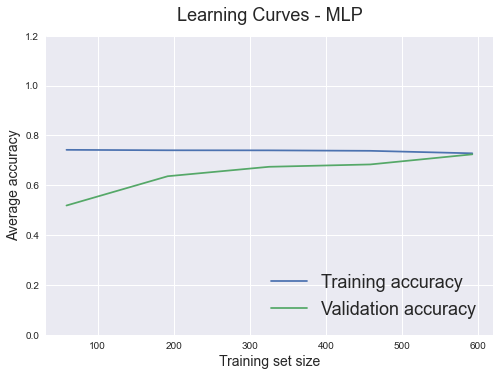

In [34]:
# calculating the mean of the scores to enable plotting. 

train_scores_MLP_mean = train_scores_MLP.mean(axis = 1)
validation_scores_MLP_mean = validation_scores_MLP.mean(axis = 1)

plt.plot(train_sizes_MLP, train_scores_MLP_mean, label = 'Training accuracy')
plt.plot(train_sizes_MLP, validation_scores_MLP_mean, label = 'Validation accuracy')
plt.ylabel('Average accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning Curves - MLP', fontsize = 18, y = 1.03)
plt.legend(loc = 'lower right', fontsize = 18)
plt.ylim(0,1.2)
plt.savefig('Learning curves - MLP')

# Support Vector Machines

Now it's time to develop our second model: Support Vector Machines. 

In [36]:
from sklearn.svm import SVC

The below cell was used to grid search for the best parameters. These parameters are used again to train and fit a model. So no need to re-run the blow cell.

In [184]:
# with gridsearch
#from sklearn.svm import SVC
  
# defining parameter range 
#param_grid = {'C': [0.1, 1, 10, 100, 1000],  
#              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
#              'kernel': ['rbf', 'linear']}  
  
#gsSVC = GridSearchCV(SVC(), param_grid, refit = True, cv = 5, scoring='accuracy') 
  
# fitting the model for grid search 
#gsSVC.fit(X_sm, y_sm) 

# printing the best score aafter hyper-parameter tuning and the best parameters 
#print(gsSVC.best_score_, gsSVC.best_params_)


0.8162162162162161 {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [37]:

#Create the SVM model after grid search
SVM_after_GS = SVC(C=1, kernel = 'rbf', gamma=1, probability=True)

#Fit the model for the data. We use exactly the same set as the one for MLP. We used scaling and SMOTE. 
SVM_after_GS.fit(X_sm, y_sm)

#Make the prediction
y_pred_GS_SVM = SVM_after_GS.predict(X_test)

print(classification_report(y_test, y_pred_GS_SVM)) 

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       130
           1       0.59      0.68      0.63        62

    accuracy                           0.74       192
   macro avg       0.71      0.73      0.72       192
weighted avg       0.76      0.74      0.75       192



In [38]:
# check the accuracy of the model
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_GS_SVM)

0.7447916666666666

In [39]:
# check confusion matrix
cm_SVM = confusion_matrix(y_test, y_pred_GS_SVM)
print(cm_SVM) 

[[101  29]
 [ 20  42]]


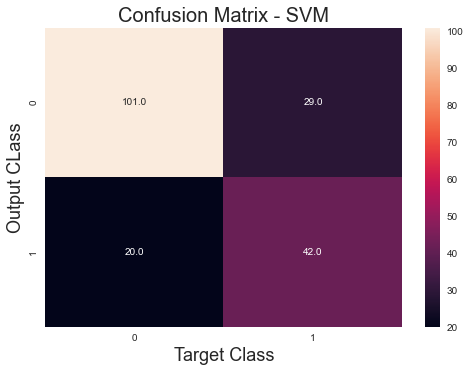

In [40]:
# plot confusion matrix
sns.heatmap(cm_SVM, annot = True, fmt = '.1f')
plt.title('Confusion Matrix - SVM', fontsize=20)
plt.xlabel('Target Class', fontsize= 18)
plt.ylabel('Output CLass', fontsize=18)
#plt.savefig('Confusion Matrix - SVM')
plt.show()

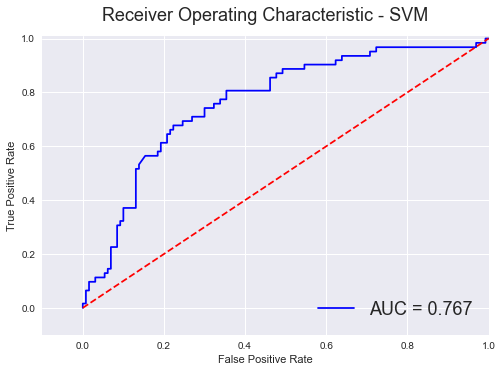

In [41]:
# plotting the ROC curve for out SVM model with best parameters

# we calculate a probability to avoid our ROC curve having an elbow shape.
yhat = SVM_after_GS.predict_proba(X_test)
pos_probs = yhat[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, pos_probs)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic - SVM', fontsize = 18, y = 1.03)
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right', fontsize = 18)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig('Receiver Operating Characteristic - SVM')
plt.show()

In [42]:
# we plot the accuracy learning curve of our model SVM_after_GS with best parameters. 

train_sizes_SVM, train_scores_SVM, validation_scores_SVM = learning_curve(SVM_after_GS, X = X_sm, y = y_sm, 
                                                                          scoring="accuracy", cv = 5)


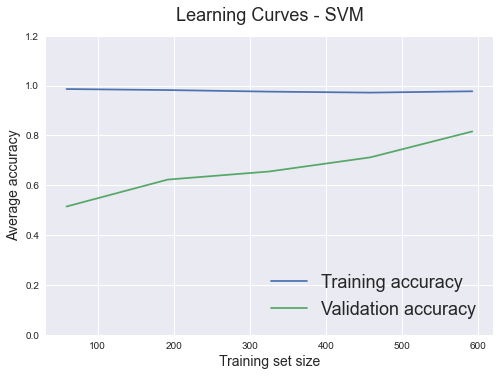

In [43]:
# calculating the mean of the scores to enable plotting. 

train_scores_SVM_mean = train_scores_SVM.mean(axis = 1)
validation_scores_SVM_mean = validation_scores_SVM.mean(axis = 1)

plt.plot(train_sizes_SVM, train_scores_SVM_mean, label = 'Training accuracy')
plt.plot(train_sizes_SVM, validation_scores_SVM_mean, label = 'Validation accuracy')
plt.ylabel('Average accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning Curves - SVM', fontsize = 18, y = 1.03)
plt.legend(loc = 'lower right', fontsize = 18)
plt.ylim(0,1.2)
plt.savefig('Learning curves - SVM')